In [1]:
from dmml_project.models.create_model import create_model
from dmml_project.model_selection.load_results import load_results, index_from_model_name
from dmml_project.metrics import f1_score
import sklearn.metrics as metrics
from dmml_project.models.model import Model
from dmml_project.models.decision_tree import DecisionTree
from dmml_project.models.random_forest import RandomForest
from dmml_project.models.neural_network import NeuralNetwork
from dmml_project import PROJECT_ROOT, PAPER_IMAGES, PAPER_TABLES
from dmml_project.dataset import Dataset
from dmml_project.utils import dataframe_to_latex
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

try_to_load = True
training_results = load_results()
model_name = "neural_network-G1-5"
generation, model_kind, model_index = index_from_model_name(model_name)
best_params = training_results[generation][model_kind][model_index][0]

match model_kind:
    case "decision_tree":
        model_class = DecisionTree
    case "random_forest":
        model_class = RandomForest
    case "neural_network":
        model_class = NeuralNetwork
    case _:
        raise ValueError(f"Unknown model kind: {model_kind}")

train_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/train.tsv")
test_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/test.tsv")
crowdflower_test_dataset: Dataset = Dataset.load(f"{PROJECT_ROOT}/data/crowdflower_test.tsv")
model: Model = create_model(kind=model_kind, **best_params)

In [2]:
history = None
model_path = f"{PROJECT_ROOT}/data/{model_name}.pkl"
can_skip = try_to_load and os.path.exists(model_path)
if can_skip:
    model = model_class.load(model_path)
else:
    history = model.train(train_dataset, valid=test_dataset)
    model.save(f"{PROJECT_ROOT}/data/{model_name}.pkl")


    
def eval_on(model: Model, dataset: Dataset, dataset_name: str):
    cm, precision, recall, f1 = model.evaluate(
        dataset, 
        metric=lambda pred, true: 
            (metrics.confusion_matrix(pred,true, normalize="true"), 
            metrics.precision_score(pred,true, average="weighted"), 
            metrics.recall_score(pred,true, average="weighted"), 
            metrics.f1_score(pred,true, average="weighted"))
        )
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")
    print(f"F1: {f1*100:.2f}%")
    table = pd.DataFrame(columns=["Metric", "Value"])
    table.loc[len(table)] = ["Precision", precision]
    table.loc[len(table)] = ["Recall", recall]
    table.loc[len(table)] = ["F1", f1]

    dataframe_to_latex(
        table, 
        caption=f"Metrics relative to the best model \\texttt{{{model_name.replace("_","\\_")}}} evaluated on the {dataset_name.replace("_"," ")} set.",
        label=f"tab:best_model_metrics_{dataset_name}",
        formatters={
            "Value": lambda x: f"{x*100:.2f}\\%"
        },
        columns_format="|X|r|",
        file=f"{PAPER_TABLES}/best_model_metrics_{dataset_name}.tex"
    )
    fig = plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".2f", annot_kws={"size": 9}, xticklabels=model.classes(), yticklabels=model.classes())
    plt.xlabel("Predicted")
    plt.xticks(rotation=45)
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"{PAPER_IMAGES}/best_model_confusion_matrix_{dataset_name}.png")
    plt.show()

Predicting: 100%|██████████| 2711/2711 [01:16<00:00, 35.36it/s, loss=2.17]


Training: 0.20380048674204307 Validation: 0.2704978633626612


Predicting: 100%|██████████| 2711/2711 [01:24<00:00, 32.03it/s, loss=2.25] 


Training: 0.47358549682124895 Validation: 0.692162766273793


Predicting: 100%|██████████| 2711/2711 [01:15<00:00, 35.92it/s, loss=2.45]  


Training: 0.8064665351533927 Validation: 0.8516638753736696


Predicting: 100%|██████████| 2711/2711 [01:23<00:00, 32.53it/s, loss=0.764] 


Training: 0.856982431637582 Validation: 0.8818145110270272


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.36it/s, loss=1.24]  


Training: 0.8701438267155307 Validation: 0.8881689490833389


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.31it/s, loss=0.946] 


Training: 0.8777277847851961 Validation: 0.8921981831146029


Predicting: 100%|██████████| 2711/2711 [01:15<00:00, 35.84it/s, loss=0.913]  


Training: 0.8815926780431594 Validation: 0.8960670843093086


Predicting: 100%|██████████| 2711/2711 [01:33<00:00, 29.08it/s, loss=1.02]    


Training: 0.8851569880512979 Validation: 0.9012094702291495


Predicting: 100%|██████████| 2711/2711 [01:20<00:00, 33.66it/s, loss=0.89]   


Training: 0.887612687758276 Validation: 0.9005819378783972


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.50it/s, loss=0.982]  


Training: 0.8907257898084462 Validation: 0.9041231454050064


Predicting: 100%|██████████| 2711/2711 [01:15<00:00, 35.81it/s, loss=1.25]    


Training: 0.8911002284627518 Validation: 0.9056426724596612


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.57it/s, loss=0.962]   


Training: 0.8911875190296481 Validation: 0.9067017319322312


Predicting: 100%|██████████| 2711/2711 [01:13<00:00, 36.69it/s, loss=0.935]  


Training: 0.8931666318808315 Validation: 0.9060546179018514


Predicting: 100%|██████████| 2711/2711 [01:13<00:00, 36.88it/s, loss=1.44]    


Training: 0.8943959644374557 Validation: 0.9080920984265336


Predicting: 100%|██████████| 2711/2711 [01:13<00:00, 36.81it/s, loss=1.12]   


Training: 0.8957215663878786 Validation: 0.9084656536208333


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.55it/s, loss=1.21]   


Training: 0.8955821254927102 Validation: 0.9079197387035167


Predicting: 100%|██████████| 2711/2711 [01:13<00:00, 36.73it/s, loss=1.43]    


Training: 0.8959431956952826 Validation: 0.9104235682713591


Predicting: 100%|██████████| 2711/2711 [01:14<00:00, 36.51it/s, loss=1.66]    


Training: 0.8970219462400514 Validation: 0.9106880924710873


Predicting: 100%|██████████| 2711/2711 [01:15<00:00, 36.02it/s, loss=1.06]   


Training: 0.8973465859197339 Validation: 0.9083857853890911


Predicting: 100%|██████████| 2711/2711 [01:13<00:00, 36.71it/s, loss=0.857]   


Training: 0.8984489129792264 Validation: 0.9106323717555098
Early stopping at epoch 20


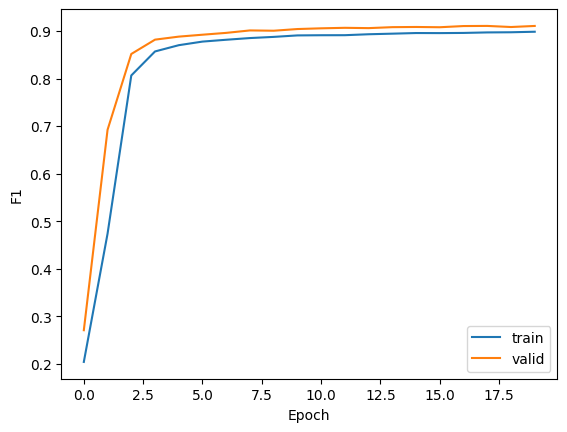

In [3]:
if history is not None:
    train_f1, valid_f1 = history
    plt.plot(train_f1, label="train")
    plt.plot(valid_f1, label="valid")
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.legend()
    plt.show()

Predicting: 100%|██████████| 2711/2711 [01:07<00:00, 39.87it/s]


Precision: 94.23%
Recall: 89.33%
F1: 91.06%


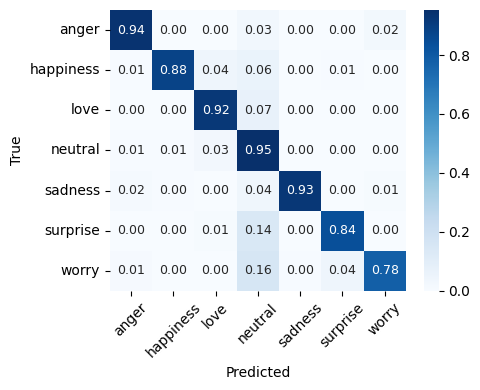

In [4]:
eval_on(model, test_dataset, "test")

Predicting: 100%|██████████| 247/247 [00:04<00:00, 53.00it/s]


Precision: 37.79%
Recall: 27.43%
F1: 15.86%


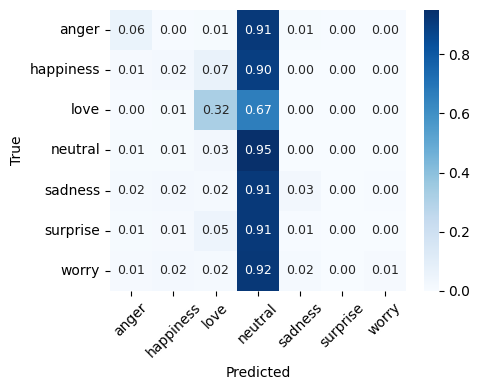

In [5]:
eval_on(model, crowdflower_test_dataset, "crowdflower_test")